# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [229]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pprint
import operator
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA    
from sklearn.preprocessing import LabelEncoder

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')


In [6]:
# Load data dictionary file
data_dict = open('Data_Dictionary.md').read()

In [7]:
print(data_dict)

# Data Dictionary for Identify Customer Segments Data

## Introduction

The data for this project consist of two files:

- Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.

### Table of Contents

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level fe

In [8]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape
azdias.head(5).T

,0,1,2,3,4
AGER_TYP,-1,-1,-1,2,-1
ALTERSKATEGORIE_GROB,2,1,3,4,3
ANREDE_KZ,1,2,2,2,1
CJT_GESAMTTYP,2,5,3,2,5
FINANZ_MINIMALIST,3,1,1,4,4
FINANZ_SPARER,4,5,4,2,3
FINANZ_VORSORGER,3,2,1,5,4
FINANZ_ANLEGER,5,5,2,2,1
FINANZ_UNAUFFAELLIGER,5,4,3,1,3
FINANZ_HAUSBAUER,3,5,5,2,2


In [10]:
feat_info.info()
feat_info.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [11]:
column_names = azdias.columns
column_names

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [12]:
# Identify missing or unknown data values and convert them to NaNs.
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))

start_time = time.time()

for attrib, missing_values in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    if missing_values[0] != '':
        for value in missing_values:
            if value.isnumeric() or value.lstrip('-').isnumeric():
                value = int(value)
            azdias.loc[azdias[attrib] == value, attrib] = np.nan
            
print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))



--- Run time: 0.8 mins ---


In [13]:
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1.0,3.0,3.0,3.0,4.0,1.0,3.0,2.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1.0,3.0,4.0,4.0,2.0,4.0,2.0,2.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2.0,4.0,2.0,4.0,2.0,3.0,5.0,4.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [14]:
azdias.to_csv('azdiasParsed.csv', sep=';', index = False)

In [4]:
#Load the post parsed processed file and redo exploratory process
azdiasParsed = pd.read_csv('azdiasParsed.csv', delimiter=';')

In [16]:
azdiasParsed.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [17]:
azdiasParsed.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,205378.000000,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,1.743410,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,0.674312,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,2.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


In [18]:
azdiasParsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null float64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null float64
FINANZ_SPARER            891221 non-null float64
FINANZ_VORSORGER         891221 non-null float64
FINANZ_ANLEGER           891221 non-null float64
FINANZ_UNAUFFAELLIGER    891221 non-null float64
FINANZ_HAUSBAUER         891221 non-null float64
FINANZTYP                891221 non-null float64
GEBURTSJAHR              498903 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILI

In [19]:
azdiasParsed.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [20]:
azdiasParsed.isnull().sum().sum()

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [5]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missingData = azdiasParsed.isnull().sum()
missingData

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [22]:
#Calculate the values
missingData = missingData[missingData > 0]/(azdiasParsed.shape[0]) * 100
missingData

AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
CJT_GESAMTTYP             0.544646
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SHOPPER_TYP              12.476816
SOHO_KZ                   8.247000
TITEL_KZ                 99.757636
VERS_TYP                 12.476816
ALTER_HH                 34.813699
ANZ_PERSONEN              8.247000
ANZ_TITEL                 8.247000
HH_EINKOMMEN_SCORE        2.058749
KK_KUNDENTYP             65.596749
W_KEIT_KIND_HH           16.605084
WOHNDAUER_2008            8.247000
ANZ_HAUSHALTE_AKTIV      11.176913
ANZ_HH_TITEL             10.884842
GEBAEUDETYP         

In [23]:
#Sort
missingData.sort_values(inplace=True)


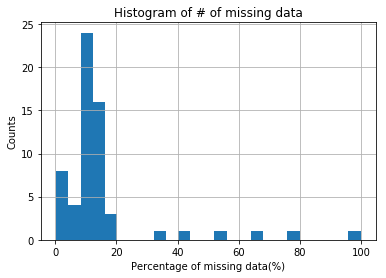

In [24]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missingData, bins = 25)

plt.xlabel('Percentage of missing data(%)')
plt.ylabel('Counts')
plt.title('Histogram of # of missing data')
plt.grid(True)
plt.show()


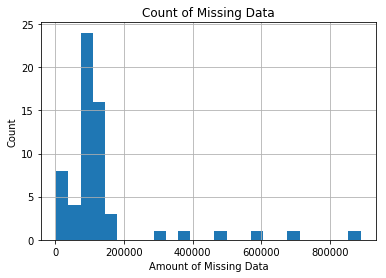

In [25]:
# Investigate patterns in the amount of missing data in each column.
missing_data = azdiasParsed.isnull().sum()
azd_total = azdiasParsed.shape[0]
missing_data = missing_data[missing_data > 0]
plt.hist(missing_data,bins=25)
plt.xlabel('Amount of Missing Data')
plt.ylabel('Count')
plt.title('Count of Missing Data')
plt.grid(True)
plt.show()

In [7]:
# Order the columns with missing data to see the top offenders
azdiasNullOrdered = azdiasParsed.isnull().sum()
azdiasNullOrdered.sort_values(inplace=True, ascending=False)
azdiasNullOrdered = azdiasNullOrdered[azdiasNullOrdered > 0]
azdiasNullOrdered

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
CAMEO_DE

In [8]:
# Percentage of the data missing from the columns
azdiasNullPercent = azdiasNullOrdered[azdiasNullOrdered > 0] / azdiasParsed.shape[0]
azdiasNullPercent

TITEL_KZ                 0.997576
AGER_TYP                 0.769554
KK_KUNDENTYP             0.655967
KBA05_BAUMAX             0.534687
GEBURTSJAHR              0.440203
ALTER_HH                 0.348137
REGIOTYP                 0.177357
KKK                      0.177357
W_KEIT_KIND_HH           0.166051
KBA05_ANTG4              0.149597
KBA05_GBZ                0.149597
MOBI_REGIO               0.149597
KBA05_ANTG1              0.149597
KBA05_ANTG2              0.149597
KBA05_ANTG3              0.149597
PLZ8_GBZ                 0.130736
PLZ8_HHZ                 0.130736
PLZ8_BAUMAX              0.130736
PLZ8_ANTG4               0.130736
PLZ8_ANTG1               0.130736
PLZ8_ANTG3               0.130736
PLZ8_ANTG2               0.130736
SHOPPER_TYP              0.124768
VERS_TYP                 0.124768
HEALTH_TYP               0.124768
NATIONALITAET_KZ         0.121536
PRAEGENDE_JUGENDJAHRE    0.121366
KBA13_ANZAHL_PKW         0.118714
ANZ_HAUSHALTE_AKTIV      0.111769
CAMEO_INTL_201

In [9]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
dropColumns = azdiasNullPercent[azdiasNullPercent > .2].index
dropColumns = dropColumns.values.tolist()
azdiasParsed.drop(dropColumns, inplace=True, axis=1)
azdiasParsed.shape



(891221, 79)

In [29]:
print(dropColumns)

['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']


In [30]:
azdiasParsed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

There were 6 columns that had more than 20% of it's values missing. These were ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']. They were removed with the .drop method. The following histogram shows the changes made after these outliers were removed.

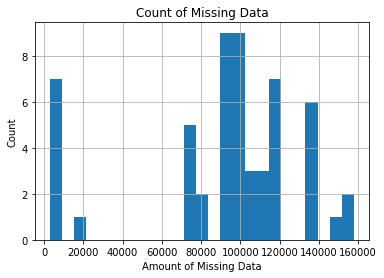

In [31]:
missing_data = azdiasParsed.isnull().sum()
azd_total = azdiasParsed.shape[0]
missing_data = missing_data[missing_data > 0]
plt.hist(missing_data,bins=25)
plt.xlabel('Amount of Missing Data')
plt.ylabel('Count')
plt.title('Count of Missing Data')
plt.grid(True)
plt.show()

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

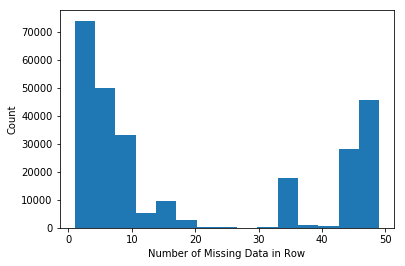

In [32]:
# How much data is missing in each row of the dataset?
nullRows = azdiasParsed.isnull().sum(axis=1)
plt.hist(nullRows[nullRows > 0], bins=15)
plt.xlabel('Number of Missing Data in Row')
plt.ylabel('Count');


In [33]:
missingRowCounts = azdiasParsed.isnull().sum(axis=1)
missingRowCounts.sort_values(ascending=False)

643174    49
732775    49
472919    48
183108    47
139316    47
691141    47
691142    47
691171    47
691183    47
139332    47
691197    47
139323    47
691212    47
691122    47
139267    47
139255    47
139250    47
139248    47
139245    47
139243    47
691317    47
691129    47
691118    47
139236    47
139478    47
690871    47
690876    47
690878    47
690887    47
139521    47
          ..
540246     0
540244     0
540243     0
540242     0
540241     0
540240     0
540239     0
540269     0
540271     0
540300     0
540289     0
540299     0
540298     0
540296     0
540295     0
540293     0
540292     0
540291     0
540290     0
540287     0
540273     0
540286     0
540284     0
540283     0
540281     0
540280     0
540277     0
540275     0
540274     0
445610     0
Length: 891221, dtype: int64

In [34]:
missingRowCounts.sum()

5035304

In [10]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
lessThan10Missing = azdiasParsed[azdiasParsed.isnull().sum(axis=1)<10].reset_index(drop=True)
moreThan10Missing = azdiasParsed[azdiasParsed.isnull().sum(axis=1)>=10].reset_index(drop=True)


In [36]:
def distplotcolumn(df1, df2, masterdf, df1_desc, df2_desc, subplot_row=5, subplot_column=2, masterdf_rows=10):
    plt.figure(figsize=(25,25))
    for i, col in enumerate(df1.columns[:masterdf_rows]):
        plt.subplot(subplot_row, subplot_column, i+1)
        sns.distplot(df1[col][df1[col].notnull()], label=df1_desc)
        sns.distplot(df2[col][df2[col].notnull()], label=df2_desc)
        plt.title ('Non-Null Distribution for Column: {}'.format(col))
        plt.legend()


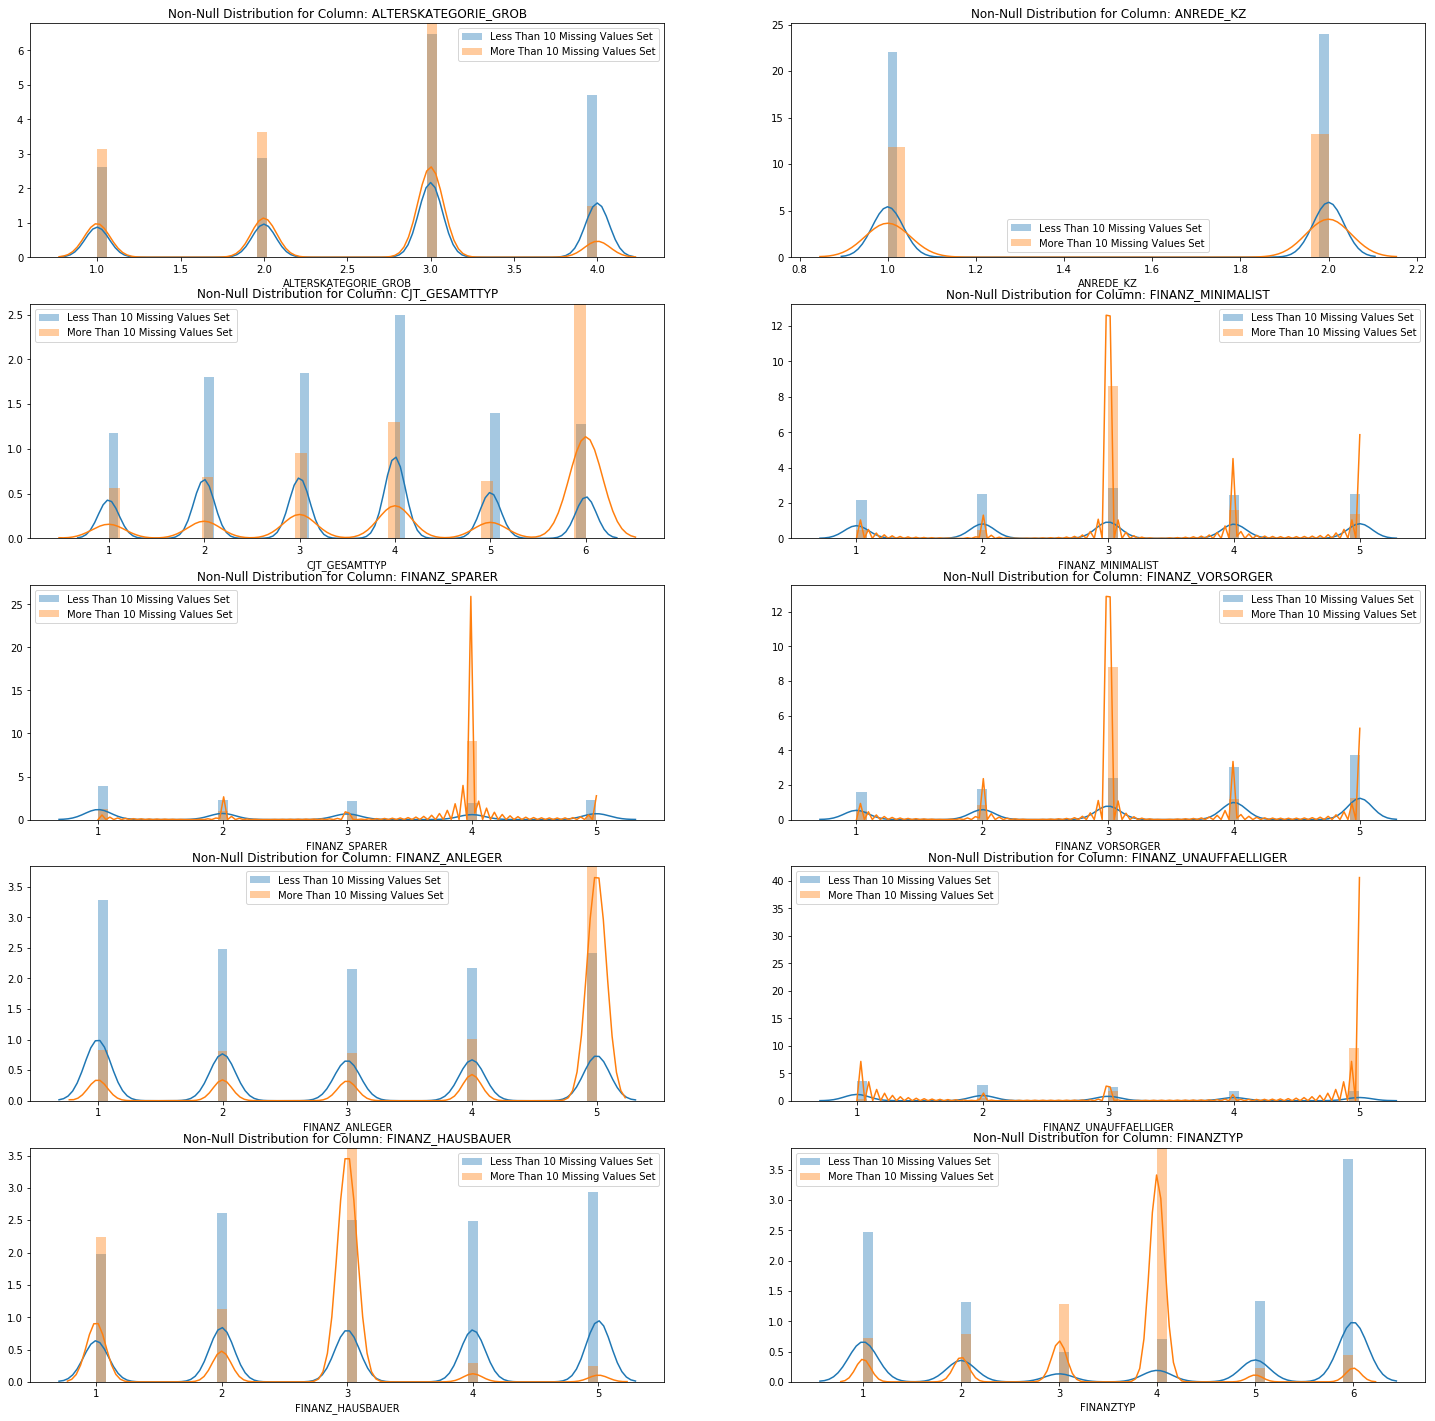

In [37]:
distplotcolumn(df1=lessThan10Missing, 
           df2=moreThan10Missing, 
           masterdf=azdiasParsed, 
           df1_desc='Less Than 10 Missing Values Set',
           df2_desc='More Than 10 Missing Values Set')

In [38]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def countplotcolumn (columns, num, df1, df2, df1_desc, df2_desc):   
    fig, ax1 = plt.subplots(num, 2, figsize=(18,25))
    fig.subplots_adjust(hspace=.4)
    ax1 = ax1.ravel()
    for i in range(num):
        sns.countplot(df1[columns[i]], ax=ax1[i*2])
        ax1[i*2].set_title(df1_desc)
        sns.countplot(df2[columns[i]], ax=ax1[i*2+1])
        ax1[i*2+1].set_title(df2_desc)

In [39]:
columns = azdiasParsed.isnull()==0
columns = columns.columns[:5].tolist()
columns

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER']

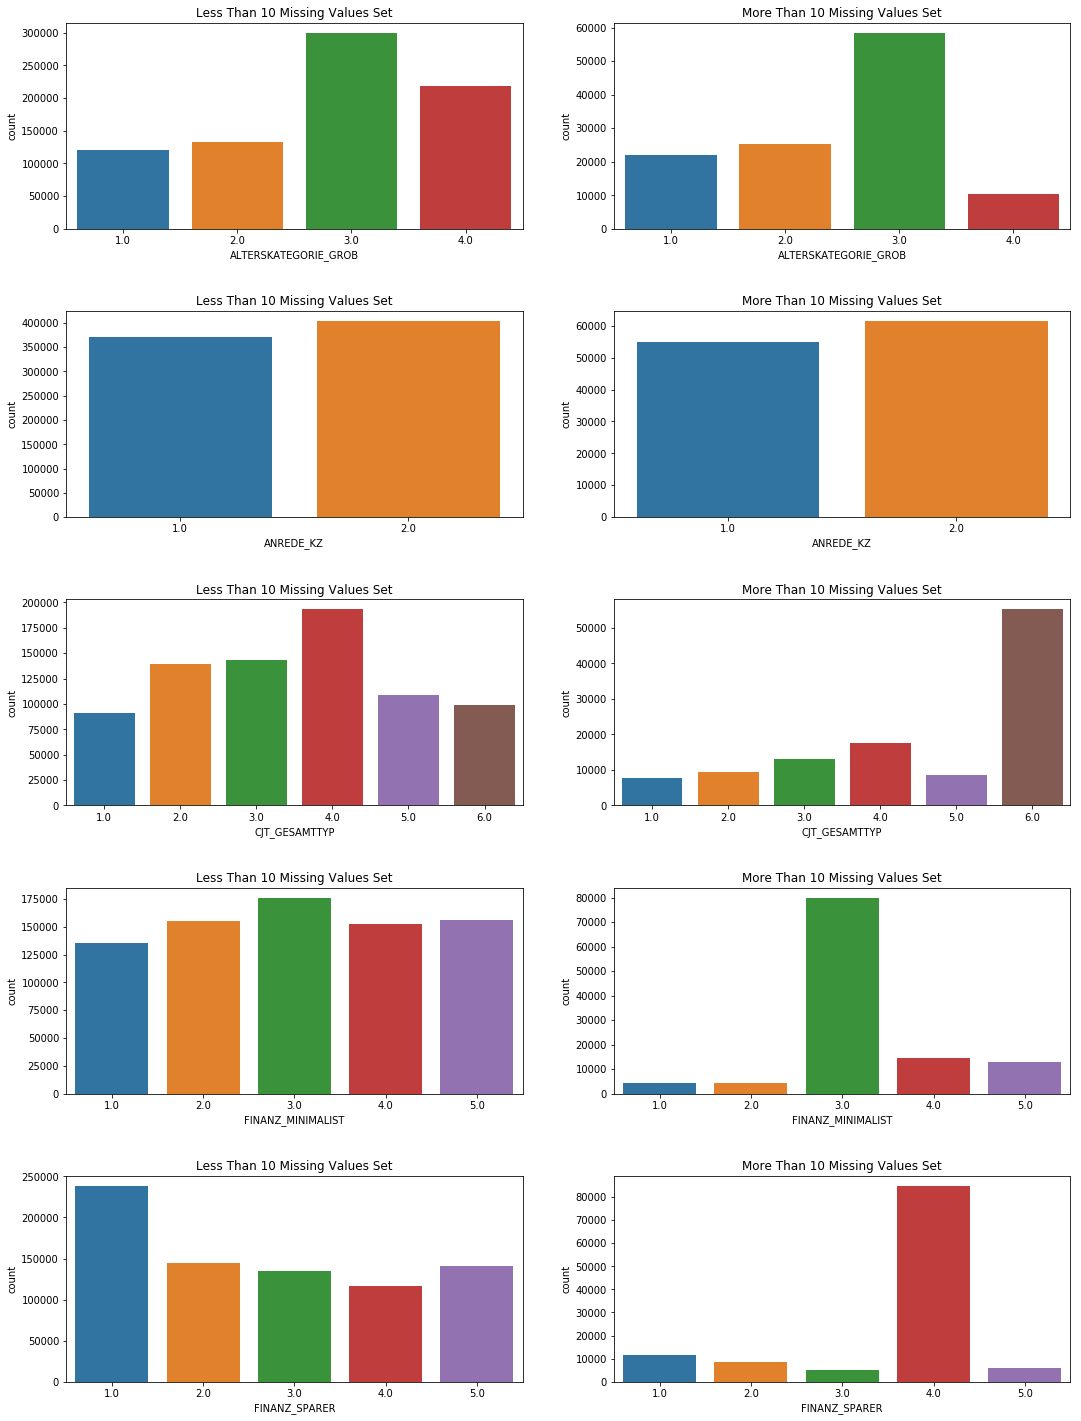

In [40]:
countplotcolumn(columns, 
                num =5, 
                df1=lessThan10Missing, 
                df2=moreThan10Missing,  
                df1_desc='Less Than 10 Missing Values Set',
                df2_desc='More Than 10 Missing Values Set' )

In [41]:
#Assess what % of data has more than 10 missing values per row
print('# Rows with more than 10 missing values:', moreThan10Missing.shape[0], 'or', \
      np.round(moreThan10Missing.shape[0]*100/missingRowCounts.shape[0],2), 
      '% of all data')

# Rows with more than 10 missing values: 116478 or 13.07 % of all data


In [42]:
#Assess what % of data has less than 10 missing values per row
print('# Rows with less than 10 missing values:', moreThan10Missing.shape[0], 'or', \
      np.round(lessThan10Missing.shape[0]*100/missingRowCounts.shape[0],2), 
      '% of all data')

# Rows with less than 10 missing values: 116478 or 86.93 % of all data


#### Discussion 1.1.3: Assess Missing Data in Each Row

Upon examination of the data, it has become evident that there exists a marked difference between the dataset with a high number of missing rows and the one with a lower number of missing rows. This has caused me to approach the decision of dropping the former dataset with a degree of caution, as discarding it would entail a significant loss of information, thus rendering our clustering algorithm inapplicable.

However, after careful consideration, I have decided to proceed with the removal of rows displaying a high number of missing data points, while simultaneously utilizing interpolation - a method of imputation based on the mean of the values in its immediate vicinity - to fill in the remaining missing values (less than 10). It is important to note that this method of imputation should be employed with a degree of circumspection, as the presence of large outliers in the data could potentially compromise its efficacy.

13.07% of the dataset has rows with more than 10 values missing. I will save this in a seperate file and then replace the missing values in the less than 10 missing values per row dataframe with the mean.

In [43]:
# Save data with 10+ missing values per row  
azdiasParsedMoreThan10Missing = azdiasParsed.iloc[moreThan10Missing.index]

In [11]:
#Replacing NaN with the mean
for col in lessThan10Missing.columns:
    lessThan10Missing[col] = lessThan10Missing[col].interpolate(limit_direction='both')

In [12]:
lessThan10Missing[col].interpolate().count()

774743

In [46]:
lessThan10Missing.head(8)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
1,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
2,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
3,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
4,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
5,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,4.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
6,1.0,1.0,3.0,3.0,3.0,4.0,1.0,3.0,2.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
7,3.0,1.0,3.0,4.0,4.0,2.0,4.0,2.0,2.0,6.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0


In [47]:
#Verifying that non NaN / Null values are present
lessThan10Missing.isnull().sum()

ALTERSKATEGORIE_GROB        0
ANREDE_KZ                   0
CJT_GESAMTTYP               0
FINANZ_MINIMALIST           0
FINANZ_SPARER               0
FINANZ_VORSORGER            0
FINANZ_ANLEGER              0
FINANZ_UNAUFFAELLIGER       0
FINANZ_HAUSBAUER            0
FINANZTYP                   0
GFK_URLAUBERTYP             0
GREEN_AVANTGARDE            0
HEALTH_TYP                  0
LP_LEBENSPHASE_FEIN         0
LP_LEBENSPHASE_GROB         0
LP_FAMILIE_FEIN             0
LP_FAMILIE_GROB             0
LP_STATUS_FEIN              0
LP_STATUS_GROB              0
NATIONALITAET_KZ            0
PRAEGENDE_JUGENDJAHRE       0
RETOURTYP_BK_S              0
SEMIO_SOZ                   0
SEMIO_FAM                   0
SEMIO_REL                   0
SEMIO_MAT                   0
SEMIO_VERT                  0
SEMIO_LUST                  0
SEMIO_ERL                   0
SEMIO_KULT                  0
                         ... 
MIN_GEBAEUDEJAHR            0
OST_WEST_KZ                 0
WOHNLAGE  

In [48]:
lessThan10Missing.isnull().sum().sum()

3456

In [13]:
#All of the remaining null values come from the same column so I will drop it.
lessThan10Missing.drop(['CAMEO_DEU_2015'], axis=1, inplace=True)

In [14]:
lessThan10Missing.isnull().sum().sum()

0

In [15]:
#Saving to csv in case we want to reload it without having to run all the previous jupyter cells
lessThan10Missing.to_csv('cleaned_dataset.csv')


Additionally, a column that persisted with a substantial number of empty values were removed. As a result, the dataset is now devoid of null values and presents a clean and organized representation of the data.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [16]:
#Set the attribute as the index
feat_info.set_index('attribute', inplace=True)

feat_info.head(n=10)

,information_level,type,missing_or_unknown
attribute,,,
AGER_TYP,person,categorical,"[-1,0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
ANREDE_KZ,person,categorical,"[-1,0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,person,ordinal,[-1]
FINANZ_SPARER,person,ordinal,[-1]
FINANZ_VORSORGER,person,ordinal,[-1]
FINANZ_ANLEGER,person,ordinal,[-1]
FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]


In [17]:
feat_info['col_names'] = feat_info.index
feat_info.head()

,information_level,type,missing_or_unknown,col_names
attribute,,,,
AGER_TYP,person,categorical,"[-1,0]",AGER_TYP
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]",ALTERSKATEGORIE_GROB
ANREDE_KZ,person,categorical,"[-1,0]",ANREDE_KZ
CJT_GESAMTTYP,person,categorical,[0],CJT_GESAMTTYP
FINANZ_MINIMALIST,person,ordinal,[-1],FINANZ_MINIMALIST


In [19]:
# How many features are there of each data type?
dType={}
for col in lessThan10Missing.columns:
    dataType = feat_info.loc[col].type
    if dataType not in dType:
        dType[dataType] = 1
    else:
        dType[dataType] += 1
    
dType

{'ordinal': 49, 'categorical': 17, 'mixed': 6, 'numeric': 6}

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [20]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
for col in lessThan10Missing.columns:
    if feat_info.loc[col].type == 'categorical':
        print(col, len(lessThan10Missing[col].unique()), lessThan10Missing[col].dtype)



ANREDE_KZ 2 float64
CJT_GESAMTTYP 6 float64
FINANZTYP 6 float64
GFK_URLAUBERTYP 12 float64
GREEN_AVANTGARDE 2 int64
LP_FAMILIE_FEIN 68 float64
LP_FAMILIE_GROB 28 float64
LP_STATUS_FEIN 10 float64
LP_STATUS_GROB 5 float64
NATIONALITAET_KZ 20 float64
SHOPPER_TYP 28 float64
SOHO_KZ 2 float64
VERS_TYP 13 float64
ZABEOTYP 6 float64
GEBAEUDETYP 7 float64
OST_WEST_KZ 2 object
CAMEO_DEUG_2015 61 float64


In [21]:
#Extract categorical columns with more than 2 categories
nonBinaryType = []
for col in lessThan10Missing.columns:
    if feat_info.loc[col].type == 'categorical' and len(lessThan10Missing[col].unique()) > 2:
        nonBinaryType.append(col)
nonBinaryType

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015']

In [22]:
# Find the column names for mixed type columns
mixedType = []
for col in lessThan10Missing.columns:
    if feat_info.loc[col].type == 'mixed':
        mixedType.append(col)
        
mixedType

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [23]:
lessThan10Missing['SHOPPER_TYP'].value_counts()

1.000000    246213
2.000000    210053
3.000000    175154
0.000000    126348
1.500000      7786
2.500000      3998
0.500000      3235
2.333333       279
1.666667       244
1.666667       222
1.333333       192
1.333333       189
2.666667       179
0.666667       150
0.666667       146
2.333333       113
0.333333        89
0.333333        79
1.250000        17
1.750000        17
2.250000        13
0.750000         9
2.750000         9
0.250000         5
1.800000         1
2.200000         1
1.400000         1
2.600000         1
Name: SHOPPER_TYP, dtype: int64

In [24]:
# Re-encode categorical variable(s) to be kept in the analysis.


#Rounding the values in the Shopper_Type column
#The float values were because of the replacing null values with the mean
#Originally they were dtype int. 
lessThan10Missing['SHOPPER_TYP'] = lessThan10Missing['SHOPPER_TYP'].round()
lessThan10Missing['SHOPPER_TYP']

0         3.0
1         2.0
2         1.0
3         2.0
4         0.0
5         1.0
6         0.0
7         3.0
8         3.0
9         2.0
10        1.0
11        3.0
12        1.0
13        2.0
14        1.0
15        2.0
16        1.0
17        1.0
18        0.0
19        0.0
20        0.0
21        1.0
22        1.0
23        1.0
24        0.0
25        1.0
26        2.0
27        2.0
28        2.0
29        1.0
         ... 
774713    0.0
774714    3.0
774715    0.0
774716    2.0
774717    0.0
774718    3.0
774719    1.0
774720    2.0
774721    1.0
774722    2.0
774723    3.0
774724    2.0
774725    3.0
774726    0.0
774727    2.0
774728    0.0
774729    3.0
774730    3.0
774731    2.0
774732    2.0
774733    1.0
774734    2.0
774735    1.0
774736    3.0
774737    1.0
774738    3.0
774739    2.0
774740    2.0
774741    0.0
774742    2.0
Name: SHOPPER_TYP, Length: 774743, dtype: float64

In [25]:
#Because values have been rounded the dtype has converted back to int64
lessThan10Missing['SHOPPER_TYP'].value_counts()


1.0    246917
2.0    222727
3.0    175343
0.0    129756
Name: SHOPPER_TYP, dtype: int64

In [26]:
# Re-encode categorical variable(s) to be kept in the analysis.
lessThan10Missing.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True);

In [27]:
lessThan10Missing = pd.get_dummies(data=lessThan10Missing, columns=['SHOPPER_TYP'])

In [28]:
lessThan10Missing.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0
0,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,1
1,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,1.0,4.0,4.0,3.0,5.0,2.0,0,0,1,0
2,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,1.0,3.0,4.0,2.0,3.0,3.0,0,1,0,0
3,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,3.0,3.0,4.0,6.0,5.0,0,0,1,0
4,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,1.0,5.0,5.0,2.0,3.0,3.0,1,0,0,0


In [29]:
lessThan10Missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774743 entries, 0 to 774742
Data columns (total 81 columns):
ALTERSKATEGORIE_GROB     774743 non-null float64
ANREDE_KZ                774743 non-null float64
CJT_GESAMTTYP            774743 non-null float64
FINANZ_MINIMALIST        774743 non-null float64
FINANZ_SPARER            774743 non-null float64
FINANZ_VORSORGER         774743 non-null float64
FINANZ_ANLEGER           774743 non-null float64
FINANZ_UNAUFFAELLIGER    774743 non-null float64
FINANZ_HAUSBAUER         774743 non-null float64
FINANZTYP                774743 non-null float64
GFK_URLAUBERTYP          774743 non-null float64
GREEN_AVANTGARDE         774743 non-null int64
HEALTH_TYP               774743 non-null float64
LP_LEBENSPHASE_FEIN      774743 non-null float64
LP_LEBENSPHASE_GROB      774743 non-null float64
LP_FAMILIE_FEIN          774743 non-null float64
LP_FAMILIE_GROB          774743 non-null float64
LP_STATUS_FEIN           774743 non-null float64
LP_STATUS

In [30]:
#Remove categorical columns with more than 2 categories
nonBinaryCols = ['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015']

for col in nonBinaryCols:
    lessThan10Missing.drop(col, axis=1, inplace=True)

In [31]:
lessThan10Missing.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,1
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,0,0,1,0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,1.0,3.0,4.0,2.0,3.0,3.0,0,1,0,0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,0,0,1,0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,1,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

First, I reviewed the different types of variables present in the data and found that there were a significant number of ordinal, categorical, and mixed variables. Ordinal variables are variables that have a natural ordered relationship, such as 'low', 'medium', 'high'. Categorical variables are variables that can take on a limited number of categories, such as 'male' or 'female'. Mixed variables are variables that contain both numerical and categorical data.

To make the data more manageable, I recoded the categorical variables. This could mean converting them into numerical values or creating new variables based on the categories. The goal of this step is to make the data more consistent and easier to work with.

I also reencoded the shopper type variable and created dummy variables for it. Dummy variables are binary variables that are used to represent a categorical variable. This allows us to include the categorical variable in our analysis without having to convert it to a numerical value.

Next, I removed the remaining non-binary columns, which are the columns that are not binary. I chose to drop them for ease of analysis, but if desired, they could also be encoded.

Lastly, I examined the mixed variables in preparation for their engineering in the next step. Engineering mixed variables typically involves separating the numerical and categorical portions of the data and creating new variables from them. This can be a complex process, but it allows us to better understand and analyze the data.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [32]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

lessThan10Missing['PRAEGENDE_JUGENDJAHRE'].head()

0    14.0
1    15.0
2     8.0
3     8.0
4     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [33]:
# this information is based on the dictionary document
#Map generation 
gen_dict = {0: [1, 2], 
            1: [3, 4],
            2: [5, 6, 7],
            3: [8, 9],
            4: [10, 11, 12, 13], 
            5:[14, 15]}

def map_gen(x):
    try:
        for key, array in gen_dict.items():
            if x in array:
                return key
    except ValueError:
        return np.nan
    
# Map movement 
mainstream = [1, 3, 5, 8, 10, 12, 14]

def map_mov(x):
    try:
        if x in mainstream:
            return 0
        else:
            return 1
    except ValueError:
        return np.nan

In [34]:
# Create generation column
lessThan10Missing['PRAEGENDE_JUGENDJAHRE_decade'] = lessThan10Missing['PRAEGENDE_JUGENDJAHRE'].apply(map_gen)

# Create movement column
lessThan10Missing['PRAEGENDE_JUGENDJAHRE_movement'] = lessThan10Missing['PRAEGENDE_JUGENDJAHRE'].apply(map_mov)

In [35]:
# Drop the original column
lessThan10Missing.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)


In [36]:
#Verify operation was successful
lessThan10Missing.columns



Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV',
       'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ',
       'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_A

In [37]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
lessThan10Missing['CAMEO_INTL_2015'].head()


0    51.0
1    24.0
2    12.0
3    43.0
4    54.0
Name: CAMEO_INTL_2015, dtype: float64

In [38]:
# Map wealth column
def map_wealth(x):
    # Check of nan first, or it will convert nan to string 'nan'
    try:
        if pd.isnull(x):
            return np.nan
        else:
            return int(str(x)[0])
    except ValueError:
        return np.nan

# Map life stage
def map_lifestage(x):
    try:
        if pd.isnull(x):
            return np.nan
        else:
            return int(str(x)[1])
    except ValueError:
        return np.nan

In [39]:
# Create wealth column
lessThan10Missing['CAMEO_INTL_2015_wealth'] = lessThan10Missing['CAMEO_INTL_2015'].apply(map_wealth)

# Create life stage column
lessThan10Missing['CAMEO_INTL_2015_lifestage'] = lessThan10Missing['CAMEO_INTL_2015'].apply(map_lifestage)

In [40]:
#Drop original column
lessThan10Missing.drop(['CAMEO_INTL_2015'], axis=1, inplace=True)

In [41]:
#Verify operation was successful
lessThan10Missing.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV',
       'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ',
       'WOHNLAGE', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER',
       'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP',
       'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3',
     

In [42]:
#Dropping other mixed type columsn 
lessThan10Missing.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB','PLZ8_BAUMAX'], axis=1, inplace=True)


In [43]:
#Verify operation was successful
lessThan10Missing.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'KBA05_ANTG1',
       'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM',
       'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ',
       'ARBEI

#### Discussion 1.2.2: Engineer Mixed-Type Features

After engineering the two mixed columns requested in the instructions I choose to drop the remaining mixed features

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [44]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
lessThan10Missing.isnull().sum()


ALTERSKATEGORIE_GROB                  0
ANREDE_KZ                             0
FINANZ_MINIMALIST                     0
FINANZ_SPARER                         0
FINANZ_VORSORGER                      0
FINANZ_ANLEGER                        0
FINANZ_UNAUFFAELLIGER                 0
FINANZ_HAUSBAUER                      0
GREEN_AVANTGARDE                      0
HEALTH_TYP                            0
RETOURTYP_BK_S                        0
SEMIO_SOZ                             0
SEMIO_FAM                             0
SEMIO_REL                             0
SEMIO_MAT                             0
SEMIO_VERT                            0
SEMIO_LUST                            0
SEMIO_ERL                             0
SEMIO_KULT                            0
SEMIO_RAT                             0
SEMIO_KRIT                            0
SEMIO_DOM                             0
SEMIO_KAEM                            0
SEMIO_PFLICHT                         0
SEMIO_TRADV                           0


In [45]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#Clear empty values from newly created columns
for col in lessThan10Missing.columns:
        lessThan10Missing[col] = lessThan10Missing[col].interpolate(limit_direction='both')

In [46]:
lessThan10Missing.isnull().sum().sum()

0

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [221]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
    feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))
   
    # Identify missing or unknown data values and convert them to NaNs.
    for attrib, missing_values in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        if missing_values[0] != '':
            for value in missing_values:
                if value.isnumeric() or value.lstrip('-').isnumeric():
                    value = int(value)
                df.loc[df[attrib] == value, attrib] = np.nan
                
    # remove selected columns and rows, ...

    #Columns
    dropColumns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 
                       'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX',
                       'CAMEO_DEU_2015']
    
    for col in dropColumns:
        df.drop(col, axis=1, inplace=True)
    
    #Rows
    #Set the attribute as the index
    feat_info.set_index('attribute', inplace=True)
    lessThan10Missing = df[df.isnull().sum(axis=1) < 10].reset_index(drop=True)
    
     #interpolate and impute the NaNs
    for col in lessThan10Missing.columns:
        lessThan10Missing[col] = lessThan10Missing[col].interpolate(limit_direction='both')
    
    # select, re-encode, and engineer column values.
    #Extract categorical columns with more than 2 categories
    
    nonBinaryCols = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN',
                       'LP_FAMILIE_GROB','LP_STATUS_FEIN','LP_STATUS_GROB','NATIONALITAET_KZ',
                       'VERS_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015']
    
    for col in nonBinaryCols:
        lessThan10Missing.drop(col, axis=1, inplace=True)
    
    #Reencode the categorical and get dummies for the shopper type
    lessThan10Missing.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True);
    lessThan10Missing['SHOPPER_TYP'] = lessThan10Missing['SHOPPER_TYP'].round()
    lessThan10Missing = pd.get_dummies(data=lessThan10Missing, columns=['SHOPPER_TYP'])
    
    # Complete the mapping process of mixed features
    lessThan10Missing['PRAEGENDE_JUGENDJAHRE_decade'] = lessThan10Missing['PRAEGENDE_JUGENDJAHRE'].apply(map_gen)
    lessThan10Missing['PRAEGENDE_JUGENDJAHRE_movement'] = lessThan10Missing['PRAEGENDE_JUGENDJAHRE'].apply(map_mov)
    lessThan10Missing.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True) 
    
    lessThan10Missing['CAMEO_INTL_2015_wealth'] = lessThan10Missing['CAMEO_INTL_2015'].apply(map_wealth)
    lessThan10Missing['CAMEO_INTL_2015_lifestage'] = lessThan10Missing['CAMEO_INTL_2015'].apply(map_lifestage)
    lessThan10Missing.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    #drop mixed columns
    mixed = ['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','PLZ8_BAUMAX']
    for col in mixed:
        lessThan10Missing.drop(col, axis=1, inplace=True)
    
    #Re-interpolate again to clean the data set
    for col in lessThan10Missing.columns:
        lessThan10Missing[col] = lessThan10Missing[col].interpolate(limit_direction='both')

    # Return the cleaned dataframe.
    return lessThan10Missing
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [48]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
lessThan10Missing.isnull().sum().sum()


0

In [49]:
# Apply feature scaling to the general population demographics data.
start_time = time.time()

scaler = StandardScaler()
lessThan10Missing[lessThan10Missing.columns] = scaler.fit_transform(lessThan10Missing[lessThan10Missing.columns].values)

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))


--- Run time: 0.32 mins ---


In [50]:
lessThan10Missing.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ORTSGR_KLS9,RELAT_AB,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
count,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,...,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05
mean,1.825462e-16,-3.738236e-17,-1.041864e-16,8.767796e-17,4.510462e-17,1.162742e-16,-3.250321e-17,1.707152e-16,6.704246e-17,-1.624794e-16,...,-1.607047e-16,4.553568e-18,-4.706729e-17,-4.792940e-17,8.034089e-18,9.776643e-18,2.685367e-17,-7.713092e-18,8.872349e-17,6.403426e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.763460e+00,-1.043381e+00,-1.488785e+00,-1.151076e+00,-1.770775e+00,-1.247929e+00,-1.171961e+00,-1.533358e+00,-5.311360e-01,-1.612046e+00,...,-1.872905e+00,-1.531613e+00,-4.485266e-01,-6.839591e-01,-6.352002e-01,-5.408612e-01,-2.297786e+00,-5.676484e-01,-1.552736e+00,-1.916286e+00
25%,-7.820297e-01,-1.043381e+00,-7.627794e-01,-1.151076e+00,-1.044684e+00,-1.247929e+00,-1.171961e+00,-8.182165e-01,-5.311360e-01,-2.732270e-01,...,-5.681676e-01,-7.950341e-01,-4.485266e-01,-6.839591e-01,-6.352002e-01,-5.408612e-01,-9.150856e-01,-5.676484e-01,-8.698078e-01,-1.250972e+00
50%,1.994002e-01,9.584224e-01,-3.677339e-02,1.944708e-01,4.074985e-01,1.103059e-01,-4.542929e-01,-1.030746e-01,-5.311360e-01,-2.732270e-01,...,-1.332551e-01,-5.845527e-02,-4.485266e-01,-6.839591e-01,-6.352002e-01,-5.408612e-01,-2.237354e-01,-5.676484e-01,4.960489e-01,7.965636e-02
75%,1.180830e+00,9.584224e-01,6.892326e-01,8.672441e-01,1.133590e+00,7.894232e-01,9.810433e-01,6.120673e-01,-5.311360e-01,1.065592e+00,...,7.365699e-01,6.781236e-01,-4.485266e-01,1.462076e+00,1.574307e+00,-5.408612e-01,1.158965e+00,-5.676484e-01,1.178977e+00,7.449705e-01
max,1.180830e+00,9.584224e-01,1.415239e+00,1.540017e+00,1.133590e+00,1.468541e+00,1.698711e+00,1.327209e+00,1.882757e+00,1.065592e+00,...,1.606395e+00,1.414702e+00,2.229522e+00,1.462076e+00,1.574307e+00,1.848903e+00,1.158965e+00,1.761654e+00,1.178977e+00,4.071541e+00


### Discussion 2.1: Apply Feature Scaling

I applied Standard Scaler to normalize the values of my dataset in order to ensure that the data is analyzed properly and that the solution provided is not affected by the varying scales within the data


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [51]:
# Apply PCA to the data.
# Apply PCA to the data.
start_time = time.time()

pca = PCA()
lessThan10MissingPca = pca.fit_transform(lessThan10Missing)
print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))



--- Run time: 0.29 mins ---


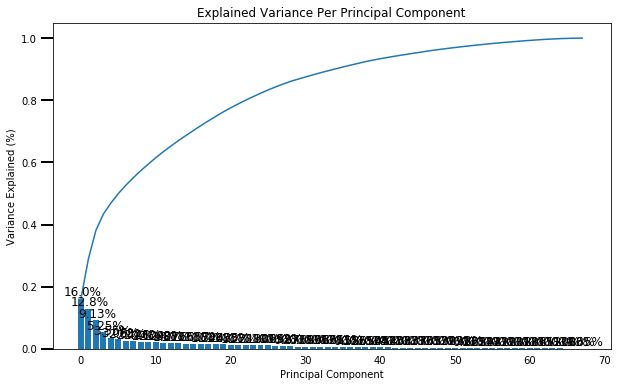

In [52]:
def pca_plot1(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

pca_plot1(pca)

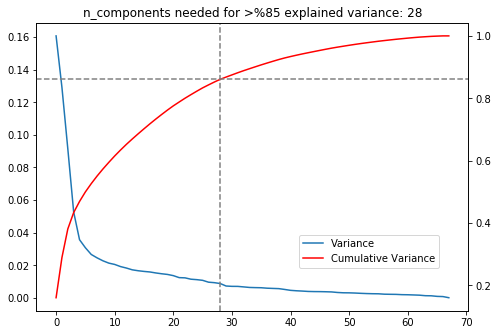

In [53]:
# Number of components required to maintain %75 variance:
def pca_plot2(pca):

    n_components = min(np.where(np.cumsum(pca.explained_variance_ratio_)>0.85)[0]+1)

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1],True)
    ax2 = ax.twinx()
    ax.plot(pca.explained_variance_ratio_, label='Variance',)
    ax2.plot(np.cumsum(pca.explained_variance_ratio_), label='Cumulative Variance',color = 'red');
    ax.set_title('n_components needed for >%85 explained variance: {}'.format(n_components));
    ax.axvline(n_components, linestyle='dashed', color='grey')
    ax2.axhline(np.cumsum(pca.explained_variance_ratio_)[n_components], linestyle='dashed', color='grey')
    fig.legend(loc=(0.6,0.2));

pca_plot2(pca)

In [249]:
# Investigate the variance accounted for by each principal component.
# Re-apply PCA to the data while selecting for number of components to retain.
start_time = time.time()

pca = PCA(n_components= 28, random_state=10)
lessThan10MissingPca = pca.fit_transform(lessThan10Missing)

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))



--- Run time: 0.38 mins ---


In [55]:
pca.explained_variance_ratio_.sum()

0.85203425981728298

### Discussion 2.2: Perform Dimensionality Reduction

PCA is a method that projects high-dimensional data onto a lower-dimensional space while retaining as much information as possible. The new features or principal components are linear combinations of the original features and are ordered by their explanatory power or variance.

From the visualizations, it was evident that the top 28 features had the highest level of explanatory power at 85%. I decided to select 28 principal components and a variance ratio of 85%, as any additional components had an insignificant explanatory power. 85% was considered a suitable percentage as it captures the majority of the variability in the data without including redundant features

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [56]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.


def pca_weights(pca, i):
    weight_map = {}
    for counter, feature in enumerate(lessThan10Missing.columns):
        weight_map[feature] = pca.components_[i][counter]
    
    sorted_weights = sorted(weight_map.items(), key=operator.itemgetter(1), reverse=True)
    
    return sorted_weights

weights = pca_weights(pca,1)

#pretty print
pprint.pprint(weights)


[('ALTERSKATEGORIE_GROB', 0.2564217306744091),
 ('SEMIO_ERL', 0.23562525608922172),
 ('FINANZ_VORSORGER', 0.22764022549690682),
 ('SEMIO_LUST', 0.18088038273905338),
 ('RETOURTYP_BK_S', 0.15895529673273359),
 ('SEMIO_KRIT', 0.12304982604405988),
 ('SEMIO_KAEM', 0.12220356600318882),
 ('FINANZ_HAUSBAUER', 0.11147079854181556),
 ('W_KEIT_KIND_HH', 0.1101524266990536),
 ('ANREDE_KZ', 0.10131335726942281),
 ('SHOPPER_TYP_3.0', 0.098480597814042975),
 ('EWDICHTE', 0.08894290653358769),
 ('ORTSGR_KLS9', 0.087844956442337502),
 ('PLZ8_ANTG3', 0.087795056105432895),
 ('PLZ8_ANTG4', 0.083436985067240774),
 ('SEMIO_DOM', 0.080827072426122706),
 ('CAMEO_INTL_2015_wealth', 0.066467631090054616),
 ('FINANZ_MINIMALIST', 0.065819565038485739),
 ('KBA05_ANTG4', 0.064612585827720809),
 ('ARBEIT', 0.063686015576177937),
 ('RELAT_AB', 0.06171413891224195),
 ('PLZ8_ANTG2', 0.060932626448907831),
 ('WOHNDAUER_2008', 0.058865878893594646),
 ('ANZ_HAUSHALTE_AKTIV', 0.05772908649216775),
 ('HH_EINKOMMEN_SCORE

In [57]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights2 = pca_weights(pca,2)


pprint.pprint(weights)



[('ALTERSKATEGORIE_GROB', 0.2564217306744091),
 ('SEMIO_ERL', 0.23562525608922172),
 ('FINANZ_VORSORGER', 0.22764022549690682),
 ('SEMIO_LUST', 0.18088038273905338),
 ('RETOURTYP_BK_S', 0.15895529673273359),
 ('SEMIO_KRIT', 0.12304982604405988),
 ('SEMIO_KAEM', 0.12220356600318882),
 ('FINANZ_HAUSBAUER', 0.11147079854181556),
 ('W_KEIT_KIND_HH', 0.1101524266990536),
 ('ANREDE_KZ', 0.10131335726942281),
 ('SHOPPER_TYP_3.0', 0.098480597814042975),
 ('EWDICHTE', 0.08894290653358769),
 ('ORTSGR_KLS9', 0.087844956442337502),
 ('PLZ8_ANTG3', 0.087795056105432895),
 ('PLZ8_ANTG4', 0.083436985067240774),
 ('SEMIO_DOM', 0.080827072426122706),
 ('CAMEO_INTL_2015_wealth', 0.066467631090054616),
 ('FINANZ_MINIMALIST', 0.065819565038485739),
 ('KBA05_ANTG4', 0.064612585827720809),
 ('ARBEIT', 0.063686015576177937),
 ('RELAT_AB', 0.06171413891224195),
 ('PLZ8_ANTG2', 0.060932626448907831),
 ('WOHNDAUER_2008', 0.058865878893594646),
 ('ANZ_HAUSHALTE_AKTIV', 0.05772908649216775),
 ('HH_EINKOMMEN_SCORE

In [58]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights3 = pca_weights(pca,3)


# Prints the nicely formatted dictionary
pprint.pprint(weights)



[('ALTERSKATEGORIE_GROB', 0.2564217306744091),
 ('SEMIO_ERL', 0.23562525608922172),
 ('FINANZ_VORSORGER', 0.22764022549690682),
 ('SEMIO_LUST', 0.18088038273905338),
 ('RETOURTYP_BK_S', 0.15895529673273359),
 ('SEMIO_KRIT', 0.12304982604405988),
 ('SEMIO_KAEM', 0.12220356600318882),
 ('FINANZ_HAUSBAUER', 0.11147079854181556),
 ('W_KEIT_KIND_HH', 0.1101524266990536),
 ('ANREDE_KZ', 0.10131335726942281),
 ('SHOPPER_TYP_3.0', 0.098480597814042975),
 ('EWDICHTE', 0.08894290653358769),
 ('ORTSGR_KLS9', 0.087844956442337502),
 ('PLZ8_ANTG3', 0.087795056105432895),
 ('PLZ8_ANTG4', 0.083436985067240774),
 ('SEMIO_DOM', 0.080827072426122706),
 ('CAMEO_INTL_2015_wealth', 0.066467631090054616),
 ('FINANZ_MINIMALIST', 0.065819565038485739),
 ('KBA05_ANTG4', 0.064612585827720809),
 ('ARBEIT', 0.063686015576177937),
 ('RELAT_AB', 0.06171413891224195),
 ('PLZ8_ANTG2', 0.060932626448907831),
 ('WOHNDAUER_2008', 0.058865878893594646),
 ('ANZ_HAUSHALTE_AKTIV', 0.05772908649216775),
 ('HH_EINKOMMEN_SCORE

### Discussion 2.3: Interpret Principal Components

The first principal component has a strong positive correlation with:<br>

+ PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region<br>
+ PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region<br>
+ CAMEO_INTL_2015_wealth: German CAMEO wealth<br>

The second principal component has a strong positive association with:<br>

+ ALTERSKATEGORIE_GROB: Estimated age based on given name analysis<br>
+ SEMIO_ERL: Personality typology, event-oriented<br>
+ FINANZ_VORSORGER: Financial typology, be prepared<br>

The third principal component has a strong positive association with:<br>

+ SEMIO_VERT: Personality typology, dreamful<br>
+ SEMIO_SOZ: Personality typology, socially-minded<br>
+ SEMIO_FAM: Personality typology, family-minded.<br>

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [59]:
# Over a number of different cluster counts...
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''

    # run k-means clustering on the data .
    kmeans = KMeans(n_clusters=center)
     # fit the model
    model = kmeans.fit(data)
    # Obtain a score related to the model fit
     # compute the average within-cluster distances
    score = np.abs(model.score(data))
    
    return score
    

In [60]:
#Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
#this takes a while
start_time = time.time()

scores = []
centers = list(range(1,30,5))

for center in centers:
    scores.append(get_kmeans_score(lessThan10MissingPca, center))
    
print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))



--- Run time: 22.31 mins ---


In [61]:
print(scores)

[44887315.341645971, 30487299.437714137, 26955731.747029983, 24703681.525266092, 23860716.880590487, 22334016.83769111]


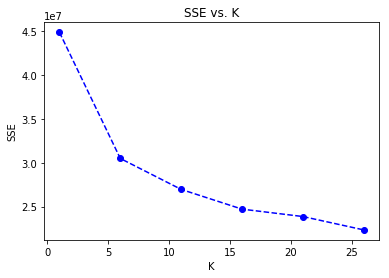

In [62]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
# SSE = sum of squared errors
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [265]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
start_time = time.time()
kmeans = KMeans(n_clusters=15)
modelGeneral = kmeans.fit(lessThan10MissingPca)
print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))




--- Run time: 3.64 mins ---


In [266]:
predictGeneral = modelGeneral.predict(lessThan10MissingPca)

### Discussion 3.1: Apply Clustering to General Population

When I was running the k-means clustering cell I was having issues getting the runtime to complete before the Udacity workspace timed out. Processing was taking over an hour each time before timing out on the workspace. So I changed the range from 1-30 with steps of 5. This did result in a plot that seemed to give me a clear elbow at 5 but from looking at the slope of the chart gave me the impression that the true elbow would be between 5 to 15 so I chose the number of clusters as 15 for the purpose of this project. I potentially would not have had this issue running the tasks locally but had already done most of the project in this workspace.



### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [223]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [206]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [183]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 191652 non-null int64
ALTERSKATEGORIE_GROB     191652 non-null int64
ANREDE_KZ                191652 non-null int64
CJT_GESAMTTYP            188439 non-null float64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_VORSORGER         191652 non-null int64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
FINANZTYP                191652 non-null int64
GEBURTSJAHR              191652 non-null int64
GFK_URLAUBERTYP          188439 non-null float64
GREEN_AVANTGARDE         191652 non-null int64
HEALTH_TYP               191652 non-null int64
LP_LEBENSPHASE_FEIN      188439 non-null float64
LP_LEBENSPHASE_GROB      188439 non-null float64
LP_FAMILIE_FEIN          188439 non-null float64
LP_FAMILIE_GROB          188439 n

Note to assessor. I'm putting the cleaning function here as well as where it was created further up in the notebook. It was easier to do the testing of the function to make sure all the parts worked together at this point. The function was created and tested iteratively. While it didn't save me any time for this particular project it was a useful activity. Some parts of the original cleaning process were not relevant for this dataset. In the future I might choose to create some of the cleaning/wrangling tasks as smaller functions which can be stacked together rather than one big function as requested by this assignment

I also refined the map functions I created earlier just to make the cells easier to run. 

In [197]:
#This is a repeat of the function created earlier just to reduce the amount of scrolling since the Udacity workspace times
#out alot and I need to rerun cells multiple times.

# this information is based on the dictionary document
#Map generation 
gen_dict = {0: [1, 2], 
            1: [3, 4],
            2: [5, 6, 7],
            3: [8, 9],
            4: [10, 11, 12, 13], 
            5:[14, 15]}

def map_gen(x):
    try:
        for key, array in gen_dict.items():
            if x in array:
                return key
    except ValueError:
        return np.nan
    
# Map movement 
mainstream = [1, 3, 5, 8, 10, 12, 14]

def map_mov(x):
    try:
        if x in mainstream:
            return 0
        else:
            return 1
    except ValueError:
        return np.nan

In [203]:
#This is a repeat of the function created earlier just to reduce the amount of scrolling since the Udacity workspace times
#out alot and I need to rerun cells multiple times.
# Map wealth column
def map_wealth(x):
    # Check of nan first, or it will convert nan to string 'nan'
    try:
        if pd.isnull(x):
            return np.nan
        else:
            return int(str(x)[0])
    except ValueError:
        return np.nan

# Map life stage
def map_lifestage(x):
    try:
        if pd.isnull(x):
            return np.nan
        else:
            return int(str(x)[1])
    except ValueError:
        return np.nan

In [224]:
#This is a repeat of the function created earlier just to reduce the amount of scrolling since the Udacity workspace times
#out alot and I need to rerun cells multiple times.
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
    feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))
   
    # Identify missing or unknown data values and convert them to NaNs.
    for attrib, missing_values in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        if missing_values[0] != '':
            for value in missing_values:
                if value.isnumeric() or value.lstrip('-').isnumeric():
                    value = int(value)
                df.loc[df[attrib] == value, attrib] = np.nan
                
    # remove selected columns and rows, ...

    #Columns
    dropColumns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 
                       'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX',
                       'CAMEO_DEU_2015']
    
    for col in dropColumns:
        df.drop(col, axis=1, inplace=True)
    
    #Rows
    #Set the attribute as the index
    feat_info.set_index('attribute', inplace=True)
    lessThan10Missing = df[df.isnull().sum(axis=1) < 10].reset_index(drop=True)
    
     #interpolate and impute the NaNs
    for col in lessThan10Missing.columns:
        lessThan10Missing[col] = lessThan10Missing[col].interpolate(limit_direction='both')
    
    # select, re-encode, and engineer column values.
    #Extract categorical columns with more than 2 categories
    
    nonBinaryCols = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN',
                       'LP_FAMILIE_GROB','LP_STATUS_FEIN','LP_STATUS_GROB','NATIONALITAET_KZ',
                       'VERS_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015']
    
    for col in nonBinaryCols:
        lessThan10Missing.drop(col, axis=1, inplace=True)
    
    #Reencode the categorical and get dummies for the shopper type
    lessThan10Missing.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True);
    lessThan10Missing['SHOPPER_TYP'] = lessThan10Missing['SHOPPER_TYP'].round()
    lessThan10Missing = pd.get_dummies(data=lessThan10Missing, columns=['SHOPPER_TYP'])
    
    # Complete the mapping process of mixed features
    lessThan10Missing['PRAEGENDE_JUGENDJAHRE_decade'] = lessThan10Missing['PRAEGENDE_JUGENDJAHRE'].apply(map_gen)
    lessThan10Missing['PRAEGENDE_JUGENDJAHRE_movement'] = lessThan10Missing['PRAEGENDE_JUGENDJAHRE'].apply(map_mov)
    lessThan10Missing.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True) 
    
    lessThan10Missing['CAMEO_INTL_2015_wealth'] = lessThan10Missing['CAMEO_INTL_2015'].apply(map_wealth)
    lessThan10Missing['CAMEO_INTL_2015_lifestage'] = lessThan10Missing['CAMEO_INTL_2015'].apply(map_lifestage)
    lessThan10Missing.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    #drop mixed columns
    mixed = ['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','PLZ8_BAUMAX']
    for col in mixed:
        lessThan10Missing.drop(col, axis=1, inplace=True)
    
    #Re-interpolate again to clean the data set
    for col in lessThan10Missing.columns:
        lessThan10Missing[col] = lessThan10Missing[col].interpolate(limit_direction='both')

    # Return the cleaned dataframe.
    return lessThan10Missing
    

In [225]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers)

In [226]:
customers_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ORTSGR_KLS9,RELAT_AB,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1,1.0,...,2.0,1.0,0,0,0,1,1.0,1,1.0,3.0
1,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1,2.0,...,5.0,3.0,0,1,0,0,1.0,1,3.0,4.0
2,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0,2.0,...,3.0,1.0,1,0,0,0,0.0,0,2.0,4.0
3,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0,3.0,...,5.0,1.0,0,1,0,0,3.0,0,4.0,1.0
4,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1,3.0,...,7.0,5.0,0,1,0,0,1.0,1,3.0,4.0


In [219]:
customers_clean.isnull().sum().sum()

0

In [227]:
customers_clean.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ORTSGR_KLS9,RELAT_AB,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
count,136215.000000,136215.000000,136215.000000,136215.000000,136215.000000,136215.000000,136215.000000,136215.000000,136215.00000,136215.000000,...,136215.000000,136215.000000,136215.000000,136215.000000,136215.000000,136215.000000,136215.000000,136215.000000,136215.000000,136215.000000
mean,3.494142,1.329604,4.270653,1.421297,4.572308,1.595999,1.844459,2.740836,0.50134,1.965591,...,5.111698,2.896370,0.217546,0.260250,0.173204,0.349000,1.873509,0.507132,2.594890,3.371886
std,0.723436,0.470071,1.015296,0.823519,0.837150,0.997407,0.963666,1.314040,0.50000,0.769553,...,2.155747,1.418981,0.412578,0.438773,0.378425,0.476656,1.339551,0.499951,1.404796,1.337816
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.00000,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,3.000000,1.000000,4.000000,1.000000,4.000000,1.000000,1.000000,2.000000,0.00000,1.000000,...,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000
50%,4.000000,1.000000,5.000000,1.000000,5.000000,1.000000,2.000000,2.000000,1.00000,2.000000,...,5.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,2.000000,4.000000
75%,4.000000,2.000000,5.000000,2.000000,5.000000,2.000000,2.000000,4.000000,1.00000,3.000000,...,7.000000,4.000000,0.000000,1.000000,0.000000,1.000000,3.000000,1.000000,4.000000,4.000000
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.00000,3.000000,...,9.000000,5.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,5.000000,5.000000


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [267]:
#normalization using StandardScaler
customers_clean[customers_clean.columns] = scaler.transform(customers_clean[customers_clean.columns].values)

In [268]:
#transform the customers data using pca object
customers_clean_pca = pca.transform(customers_clean)

In [269]:
#predict clustering using the kmeans object
predict_customers = modelGeneral.predict(customers_clean_pca)

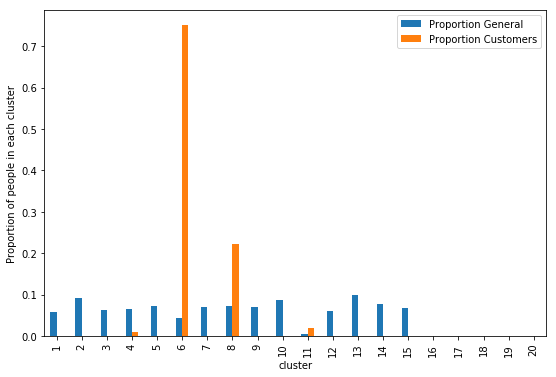

In [270]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
generalProp = []
customersProp = []
x = [i+1 for i in range(20)]
for i in range(20):
    generalProp.append((predictGeneral == i).sum()/len(predictGeneral))
    customersProp.append((predict_customers == i).sum()/len(predict_customers))


df_general = pd.DataFrame({'cluster' : x, 'Proportion General' : generalProp, 'Proportion Customers':customersProp})

#ax = sns.countplot(x='index', y = df_general['prop_1', 'prop_2'], data=df_general )
df_general.plot(x='cluster', y = ['Proportion General', 'Proportion Customers'], kind='bar', figsize=(9,6))
plt.ylabel('Proportion of people in each cluster')
plt.show()


In [271]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

data = scaler.inverse_transform(pca.inverse_transform(customers_clean_pca[np.where(predict_customers==8)])).round()
df = pd.DataFrame(data=data,
          index=np.array(range(0, data.shape[0])),
          columns=lessThan10Missing.columns)
df.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ORTSGR_KLS9,RELAT_AB,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage


In [272]:
data_2 = scaler.inverse_transform(pca.inverse_transform(lessThan10MissingPca[np.where(predictGeneral==8)])).round()
df_2 = pd.DataFrame(data=data_2,
          index=np.array(range(0, data_2.shape[0])),
          columns=lessThan10Missing.columns)
df_2.head(10)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ORTSGR_KLS9,RELAT_AB,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
0,3.0,2.0,2.0,4.0,2.0,4.0,4.0,4.0,1.0,3.0,...,6.0,2.0,-0.0,0.0,1.0,0.0,4.0,1.0,2.0,4.0
1,3.0,2.0,3.0,3.0,4.0,3.0,2.0,3.0,0.0,2.0,...,8.0,4.0,0.0,-0.0,1.0,0.0,3.0,0.0,4.0,1.0
2,3.0,2.0,3.0,2.0,4.0,2.0,2.0,3.0,0.0,3.0,...,8.0,4.0,-0.0,0.0,-0.0,1.0,3.0,-0.0,5.0,1.0
3,3.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,3.0,...,5.0,5.0,0.0,-0.0,1.0,-0.0,3.0,0.0,4.0,3.0
4,3.0,2.0,2.0,3.0,3.0,3.0,2.0,3.0,0.0,3.0,...,4.0,3.0,0.0,-0.0,1.0,0.0,4.0,0.0,4.0,2.0
5,4.0,2.0,3.0,3.0,4.0,3.0,2.0,3.0,-0.0,3.0,...,2.0,3.0,-0.0,0.0,1.0,0.0,3.0,-0.0,5.0,1.0
6,3.0,2.0,2.0,5.0,2.0,5.0,5.0,3.0,1.0,3.0,...,7.0,3.0,-0.0,0.0,1.0,0.0,5.0,1.0,3.0,3.0
7,3.0,2.0,2.0,3.0,4.0,3.0,3.0,4.0,0.0,2.0,...,6.0,5.0,0.0,-0.0,1.0,-0.0,4.0,0.0,5.0,2.0
8,3.0,2.0,2.0,2.0,4.0,2.0,3.0,4.0,0.0,2.0,...,7.0,4.0,-0.0,0.0,1.0,0.0,3.0,0.0,3.0,4.0
9,3.0,2.0,3.0,1.0,5.0,1.0,1.0,4.0,-0.0,3.0,...,6.0,4.0,0.0,-0.0,1.0,0.0,2.0,-0.0,3.0,4.0


In [273]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

data_3 = scaler.inverse_transform(pca.inverse_transform(customers_clean_pca[np.where(predict_customers==13)])).round()
df = pd.DataFrame(data=data_3,
          index=np.array(range(0, data_3.shape[0])),
          columns=lessThan10Missing.columns)
df.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ORTSGR_KLS9,RELAT_AB,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
0,6.0,-2.0,-65.0,26.0,17.0,-34.0,-128.0,200.0,7.0,15.0,...,24.0,-14.0,-23.0,9.0,32.0,-17.0,5.0,0.0,135.0,137.0
1,4.0,-1.0,-61.0,27.0,18.0,-30.0,-123.0,201.0,35.0,12.0,...,29.0,-13.0,-24.0,10.0,33.0,-17.0,5.0,31.0,135.0,131.0
2,5.0,-2.0,-65.0,27.0,16.0,-34.0,-127.0,199.0,7.0,15.0,...,24.0,-14.0,-23.0,9.0,32.0,-17.0,6.0,0.0,135.0,137.0
3,4.0,-1.0,-61.0,27.0,18.0,-30.0,-123.0,200.0,35.0,12.0,...,29.0,-13.0,-24.0,10.0,33.0,-17.0,6.0,31.0,135.0,130.0
4,6.0,-2.0,-65.0,26.0,17.0,-34.0,-127.0,200.0,7.0,12.0,...,24.0,-14.0,-23.0,9.0,32.0,-17.0,5.0,0.0,135.0,137.0
5,6.0,-2.0,-65.0,26.0,17.0,-34.0,-127.0,199.0,7.0,15.0,...,23.0,-15.0,-23.0,9.0,32.0,-17.0,6.0,0.0,135.0,137.0
6,4.0,-1.0,-61.0,27.0,18.0,-30.0,-123.0,200.0,35.0,12.0,...,29.0,-13.0,-24.0,10.0,33.0,-17.0,6.0,31.0,135.0,131.0
7,6.0,-2.0,-65.0,26.0,17.0,-34.0,-127.0,200.0,7.0,15.0,...,24.0,-15.0,-23.0,9.0,32.0,-17.0,6.0,0.0,135.0,137.0
8,5.0,-2.0,-65.0,27.0,16.0,-34.0,-127.0,199.0,7.0,15.0,...,24.0,-15.0,-23.0,9.0,32.0,-17.0,6.0,0.0,135.0,137.0
9,4.0,-1.0,-61.0,27.0,18.0,-30.0,-123.0,200.0,35.0,12.0,...,29.0,-14.0,-24.0,10.0,33.0,-17.0,5.0,31.0,135.0,131.0


In [274]:
data_4 = scaler.inverse_transform(pca.inverse_transform(lessThan10MissingPca[np.where(predictGeneral==13)])).round()
df = pd.DataFrame(data=data_4,
          index=np.array(range(0, data_4.shape[0])),
          columns=lessThan10Missing.columns)
df.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ORTSGR_KLS9,RELAT_AB,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
0,2.0,1.0,3.0,2.0,4.0,1.0,1.0,4.0,0.0,3.0,...,7.0,3.0,0.0,-0.0,1.0,-0.0,2.0,0.0,5.0,1.0
1,3.0,1.0,3.0,1.0,5.0,1.0,2.0,4.0,-0.0,3.0,...,8.0,4.0,-0.0,1.0,0.0,-0.0,2.0,-0.0,3.0,5.0
2,4.0,1.0,3.0,1.0,5.0,1.0,1.0,4.0,-0.0,2.0,...,7.0,4.0,-0.0,0.0,1.0,-0.0,1.0,-0.0,5.0,1.0
3,4.0,1.0,3.0,2.0,5.0,1.0,1.0,4.0,-0.0,2.0,...,7.0,3.0,-0.0,0.0,1.0,0.0,2.0,0.0,6.0,1.0
4,3.0,1.0,4.0,2.0,4.0,1.0,2.0,2.0,0.0,3.0,...,9.0,4.0,0.0,-0.0,1.0,-0.0,3.0,0.0,5.0,2.0
5,4.0,1.0,3.0,2.0,5.0,0.0,2.0,4.0,0.0,1.0,...,8.0,4.0,0.0,-0.0,0.0,1.0,2.0,0.0,5.0,1.0
6,3.0,1.0,3.0,2.0,4.0,2.0,2.0,3.0,-0.0,3.0,...,8.0,5.0,-0.0,1.0,-0.0,0.0,3.0,0.0,5.0,1.0
7,4.0,1.0,3.0,1.0,5.0,1.0,1.0,5.0,-0.0,2.0,...,8.0,3.0,-0.0,0.0,0.0,1.0,1.0,-0.0,3.0,4.0
8,4.0,1.0,3.0,2.0,5.0,2.0,2.0,4.0,-0.0,2.0,...,4.0,2.0,-0.0,0.0,0.0,1.0,2.0,-0.0,5.0,1.0
9,4.0,1.0,4.0,1.0,5.0,2.0,0.0,5.0,-0.0,2.0,...,5.0,5.0,-0.0,-0.0,1.0,0.0,1.0,-0.0,5.0,5.0


### Discussion 3.3: Compare Customer Data to Demographics Data

Customer data is over represented in clusters 6, 8 and 11 while underrepresented in every other cluster. It's not enough information for me to make a clear inference as to the relationship between the customer data set and the demographics data. They may simply be too different to compare or we may have removed too much useful information in our cleaning process. I don't have enough experience to confidentally state. This project was very challenging for me and I will be looking forward to studying these concepts more in depth in the future.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.